In [1]:
import numpy as np
import matplotlib

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
from scipy import stats
from scipy import integrate
from scipy import special as sp
import plasmapy.mathematics
import scipy.optimize as op
from functools import partial
from scipy import integrate
from prettytable import PrettyTable
%config InlineBackend.figure_format = 'svg'

In [159]:
tem = 1
L = 20
vmax = 100
grid_num = 100
N = 1000000
k = 2*np.pi/L

nx = grid_num+1
#nx = 101
nv = 1001
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V, X = np.meshgrid(v, x)

dt = 0.1
max_steps  = 30000
data_steps = 10000
data_num = int(max_steps/data_steps) + 1

kappa = 1.0
B = 0.2

path = '../data/'

m=1
n=N/L
q=np.sqrt(1/n)
v_th = np.sqrt(2*tem)
l_D = np.sqrt( tem) # $\lambda_D^2$
w_pe = 1
print("data_num = ",data_num)

data_num =  4


## 理论公式
$$n_e^* = A[1-\frac{\Delta}{k^2 \lambda^2 \kappa_0} \cos(kx)]^{-\kappa_0-1}$$
$$n_i^* = A[1-\frac{\Delta}{k^2 \lambda^2 \kappa_0} \cos(kx)]^{-\kappa_0-1} + \Delta \cos(kx)$$
$$A^{-1} = \int_0^L [1-\frac{\Delta}{k^2 \lambda^2 \kappa_0} \cos(kx)]^{-\kappa_0-1} dx$$

In [136]:
d = B*k**2*kappa*l_D**2

if B>=1:
    print("warning B>=1 !!")

def unnorm_n(x):
    r = (1 - B * np.cos(k*x))**(-kappa-1)
    return r

norm = integrate.quad(unnorm_n, 0, L)
print(norm)

A =  L * 1.0 / norm[0]

def ne(x):
    r = A * unnorm_n(x)
    return r

def ni(x):
    r = ne(x) + d*np.cos(k*x)
    return r

def T_theo(x):
    #return tem * A**(-1.0/(kappa+1)) * (1 - B * np.cos(k*x))
    return tem*ne(x)**(-1.0/(kappa+1))

def f_homo(v, t, kappa):
    if(kappa == 0):
        r = np.sqrt(1./(2.*np.pi*t))*np.exp(-v**2/(2*t))
    else:
        r = np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r

def f_inhomo(x, v, kappa):
    t = T_theo(x)
    if(kappa == 0):
        r = f_homo(v, t, kappa)
    else:
        r = ne(x)*np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r

def fv_nonvec(vv, kk):
    r = integrate.quad(partial(f_inhomo, v=vv, kappa=kk), 0, L)[0]
    return r


fv_theo = np.vectorize(fv_nonvec)

(21.262931794992866, 1.5328161927410092e-11)


## 模拟结果

In [160]:
progesses = np.arange(0,data_num,1)

xdata = []
vdata = []
tdata = []

for progess in progesses:
    x_temp = np.loadtxt(os.path.join(path,"electronsx_data"+str(progess)))
    xdata.append(x_temp)
    v_temp = np.loadtxt(os.path.join(path,"electronsv_data"+str(progess)))
    vdata.append(v_temp)
    t_temp = np.loadtxt(os.path.join(path,"temperature"+str(progess)))
    tdata.append(t_temp)

In [161]:
dataet = np.loadtxt(os.path.join(path, "tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path, "pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path, "kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

In [162]:
def pdf(data,data_bins):##统计分布函数
    f, edges = np.histogram(data, bins=data_bins, density=True)
    x = (edges[0:len(edges)-1]+edges[1:len(edges)])/2
    dx = edges[1]-edges[0]
    return f, x, dx
def pdf2d(x,y,datax_bins,datay_bins):
    f,xedges,yedges = np.histogram2d(x,y,bins=[datax_bins,datay_bins],density=True)
    x = (xedges[0:len(xedges)-1]+xedges[1:len(xedges)])/2
    y = (yedges[0:len(yedges)-1]+yedges[1:len(yedges)])/2
    dx = xedges[1]-xedges[0]
    dy = yedges[1]-yedges[0]
    return f,x,y,dx,dy

In [163]:
def e(pdf,xw,vw):
    r = 0.0
    for x in pdf:
        for i in x:
            if i == 0.0:
                r += 0.0
            else: 
                r += i**2
                #r +=- i * np.log(i)
    return r * vw * xw

f0xv, x_f0xv, v_f0xv, dx_f0xv,dv_f0xv = pdf2d(xdata[0],vdata[0],nx,nv)
Ek_init = dataek[0]
Ep_init = dataep[0]
Et_init = dataet[0]
S_init = e(f0xv,dx_f0xv,dv_f0xv)

fxv, x_fxv, v_fxv, dx_fxv,dv_fxv = pdf2d(xdata[data_num-1],vdata[data_num-1],nx,nv)
Ek_fin = dataek[max_steps-1]
Ep_fin = dataep[max_steps-1]
Et_fin = dataet[max_steps-1]
S_fin = e(fxv,dx_fxv,dv_fxv)

In [164]:
err_E = (Et_init-Et_fin)/Et_init*100
err_S = (S_init-S_fin)/S_init*100
table = PrettyTable(['',  'Ek',    'Ep',    'Et',    'S'])
table.add_row(['initial',  Ek_init, Ep_init, Et_init, S_init])
table.add_row(['final',    Ek_fin,  Ep_fin,  Et_fin,  S_fin])
table.add_row(['error(%)', '-',     '-',     err_E,   err_S])
table.float_format = .6
print(table)

+----------+----------+----------+-----------+----------+
|          |    Ek    |    Ep    |     Et    |    S     |
+----------+----------+----------+-----------+----------+
| initial  | 0.497973 | 0.000955 |  0.498928 | 0.019098 |
|  final   | 0.498021 | 0.001060 |  0.499082 | 0.019085 |
| error(%) |    -     |    -     | -0.030812 | 0.071058 |
+----------+----------+----------+-----------+----------+


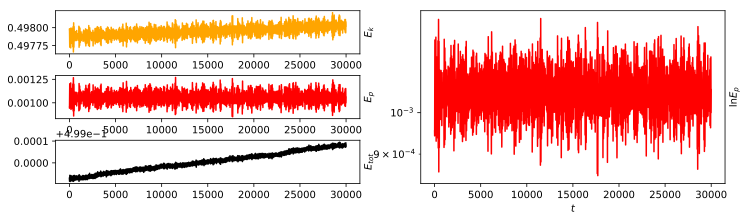

In [165]:
fig = plt.figure(figsize=(12, 3))

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 2), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.2)
plt.xlabel(r'$t$')
plt.show()

In [166]:
#initial pdf
fv0,v_fv0,dv_fv0 = pdf(vdata[0],nv)
fx0,x_fx0,dx_fx0 = pdf(xdata[0],nx)
#final pdf
fv,v_fv,dv_fv=pdf(vdata[data_num-1],nv)
fx,x_fx,dx_fx=pdf(xdata[data_num-1],nx)
#initial T
Z0,x_Z0,v_Z0,dx_Z0,dv_Z0 = pdf2d(xdata[0],vdata[0],nx,nv)
Zx0 = np.sum(Z0,axis=1)*dv_Z0
T0 = np.sum(v_Z0**2*Z0,axis=1)*dv_Z0/Zx0
#final T
Z,x_Z,v_Z,dx_Z,dv_Z = pdf2d(xdata[data_num-1],vdata[data_num-1],nx,nv)
Zx = np.sum(Z,axis=1)*dv_Z
T = np.sum(v_Z**2*Z,axis=1)*dv_Z/Zx

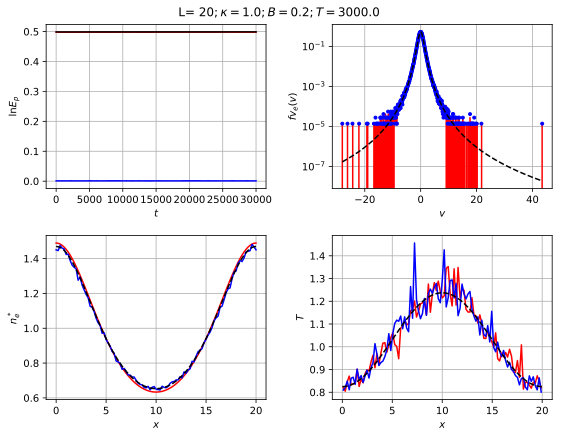

In [173]:
fig = plt.figure(figsize=(8, 6))

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.plot(t, dataep, color='blue')
ax1.plot(t, dataek, color='red')
ax1.plot(t, dataet, color='black')
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$\ln E_p$')
#ax1.set_yscale('log')
ax1.grid()

ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.plot(v_fv0,fv0,color='red', label='initial')
ax2.plot(v_fv, fv, '.',color='blue',label='final')
ax2.plot(v_fv, fv_theo(v_fv,kappa)/L,'--',color='black',label='theory')
ax2.set_xlabel(r'$v$')
ax2.set_ylabel(r'$fv_{e}(v)$')
ax2.set_yscale('log')
ax2.grid()

ax3 = plt.subplot2grid((2, 2), (1, 0))
ax3.plot(x, ni(x), color='r',    label='initial')
ax3.plot(x, fx*L,  color='blue', label='final')
ax3.plot(x, ne(x), '--', color='black', label='theo')
ax3.set_xlabel(r'$x$')
ax3.set_ylabel(r'$n_e^*$')
ax3.grid()

#x_tdata = x[0:nx-1]+dx/2
ax4 = plt.subplot2grid((2, 2), (1, 1))
ax4.plot(x_Z0, T0, color='r',   label='initial')
ax4.plot(x_Z, T ,color='blue',label='final')
ax4.plot(x, T_theo(x), '--', color='black', label='theo')
#plt.plot(x_tdata,tdata[data_num-1],color='orange')
ax4.set_xlabel(r'$x$')
ax4.set_ylabel(r'$T$')
ax4.grid()

title_text = "L= " + str(L) + r"$; \kappa= $" + str(kappa) + r"$; B= $" + str(B) + r"$; T= $" + str(max_steps*dt)
fig.suptitle(title_text,va='bottom')
plt.tight_layout()
#plt.savefig("../results/analytic_inhomogeneous_kappa_plasma/1.png", dpi=600,bbox_inches = 'tight')
plt.show()

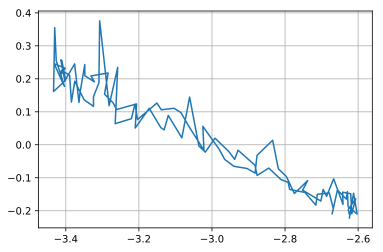

LinregressResult(slope=-1.770196447213208, intercept=-2.98894978793523, rvalue=-0.9587505839437507, pvalue=6.8721351993813e-56, stderr=0.052746870514058505)


In [168]:
plt.plot(np.log(fx),np.log(T))
plt.grid()
plt.show()
print(stats.linregress(np.log(T),np.log(fx)))

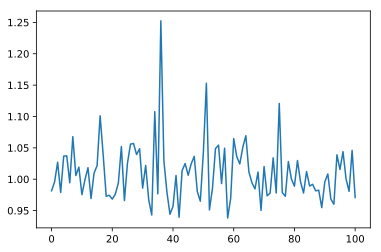

In [169]:
plt.plot(T/T_theo(x))

In [170]:
T.mean()/T_theo(x).mean()

1.0103036102932803